# eda004
誤差分析

In [87]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px

# utils

In [88]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [89]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [90]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

# data prep

In [91]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [92]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [93]:
train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

In [94]:
# ground_truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))
print('ground_truth.csv count : ', len(gt_files))

gts = []
for gt_file in tqdm(gt_files):
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

display(ground_truth.head())

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-21-US-MTV-2,Pixel4,1274131364434,37.628927,-122.426295,65.36,64.43,2.6,0.0,0.0,154.3
1,2020-05-21-US-MTV-2,Pixel4,1274131365434,37.628927,-122.426295,65.36,65.43,2.6,0.0,0.0,154.3
2,2020-05-21-US-MTV-2,Pixel4,1274131366434,37.628927,-122.426295,65.36,66.43,2.6,0.0,0.0,154.3
3,2020-05-21-US-MTV-2,Pixel4,1274131367434,37.628927,-122.426295,65.36,67.43,2.6,0.0,0.0,154.3
4,2020-05-21-US-MTV-2,Pixel4,1274131368434,37.628927,-122.426295,65.36,68.43,2.6,0.0,0.0,154.3


In [95]:
ground_truth = ground_truth.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt', 'heightAboveWgs84EllipsoidM':'heightAboveWgs84EllipsoidM_gt'})

train = train.merge(ground_truth, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')

train['latDeg_err'] = train['latDeg'] - train['latDeg_gt']
train['lngDeg_err'] = train['lngDeg'] - train['lngDeg_gt']
train['heightAboveWgs84EllipsoidM_err'] = train['heightAboveWgs84EllipsoidM'] - train['heightAboveWgs84EllipsoidM_gt']

train['dist_err'] = calc_haversine(train['latDeg_gt'], train['lngDeg_gt'], train['latDeg'], train['lngDeg'])

train = add_distance_diff(train)

In [96]:
th = 50
train_ro = train[((train['dist_prev'] <= th) & (train['dist_next'] <= th))].copy()

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

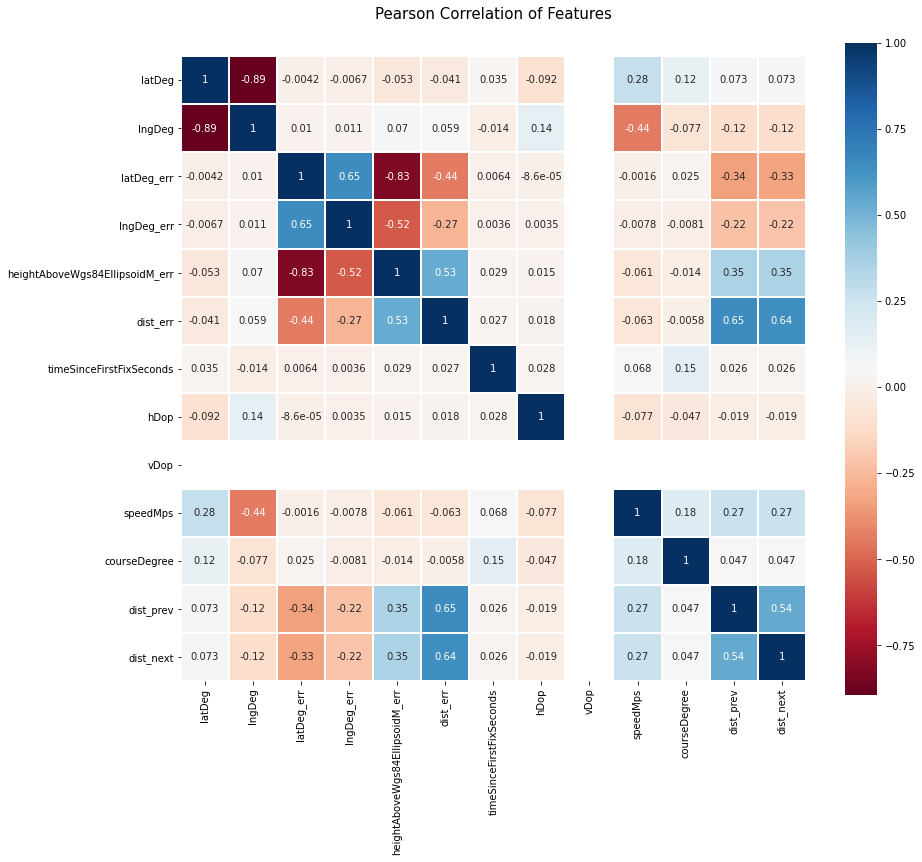

In [110]:
cols = ['latDeg', 'lngDeg', 'latDeg_err', 'lngDeg_err', 'heightAboveWgs84EllipsoidM_err', 'dist_err', 'timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree', 'dist_prev', 'dist_next']
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[cols].corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

<AxesSubplot:title={'center':'Reject_outlier'}>

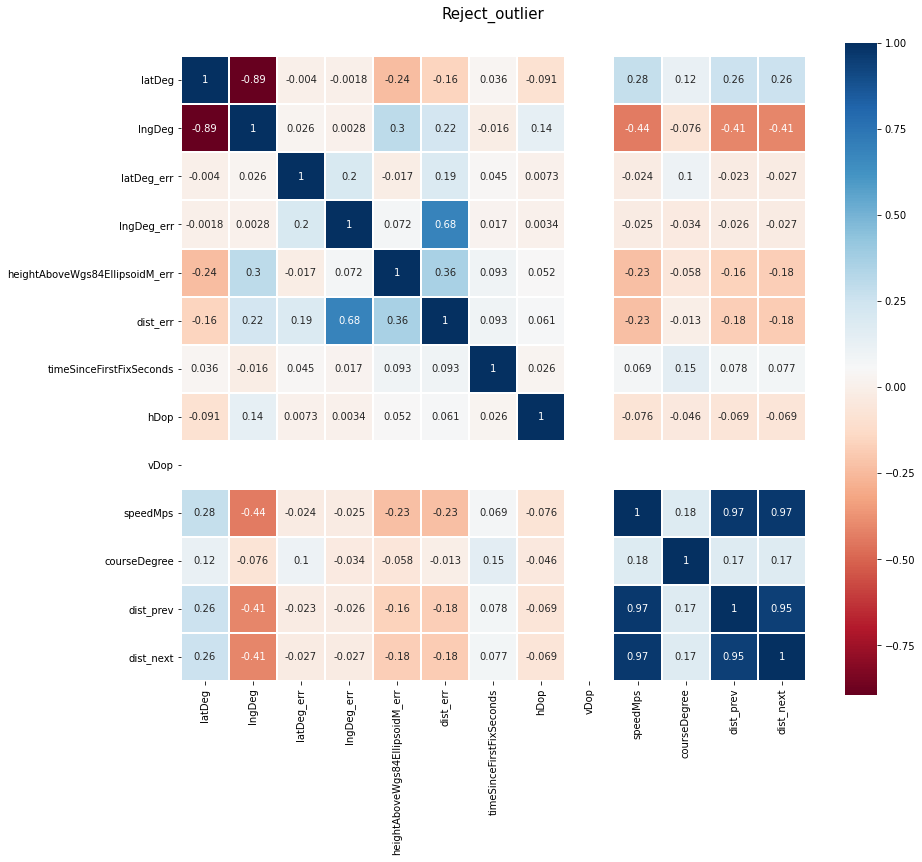

In [111]:
plt.figure(figsize=(14,12))
plt.title('Reject_outlier', y=1.05, size=15)
sns.heatmap(train_ro[cols].corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [121]:
phones = train_ro['phone'].unique()

# 各数値の推移

In [129]:
for phone in phones:
    tmp = train_ro[train_ro['phone']==phone].copy()

    fig, axes = plt.subplots(figsize=(50, 20), nrows=len(cols),sharex=True)
    for i,c in enumerate(cols):
        axes[i].plot(tmp['millisSinceGpsEpoch'], tmp[c], label=c)
        axes[i].legend(loc='lower right')
        fig.suptitle(phone, fontsize=16)
        fig.savefig(OUTPUT + '/' + phone + '.png')
        plt.close()

# 速度0での誤差

<AxesSubplot:>

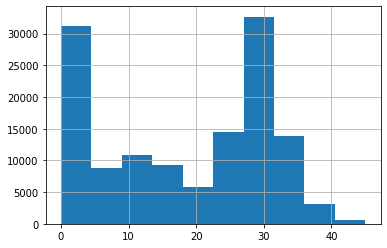

In [135]:
train_ro['speedMps'].hist()

In [140]:
train_ro.loc[train_ro['speedMps']==0.0,'speed0'] = 'speed = 0'
train_ro.loc[train_ro['speedMps']>0.0,'speed0'] = 'speed > 0'

In [142]:
train_ro[train_ro['speedMps']==0.0]['dist_err'].mean()

6.328600649281078

In [143]:
train_ro[train_ro['speedMps']>0.0]['dist_err'].mean()

2.9098555612764323

<AxesSubplot:xlabel='speed0', ylabel='dist_err'>

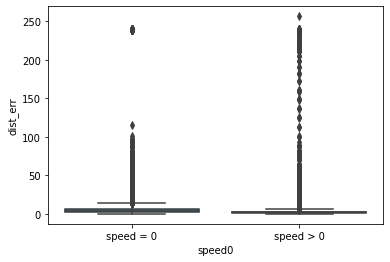

In [141]:
sns.boxplot(x='speed0', y='dist_err', data=train_ro)